### Imports

In [93]:
import numpy as np

import pandas as pd
import pandas_profiling

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from category_encoders import TargetEncoder

from matplotlib import pyplot as plt 
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import seaborn as sns

import missingno as mno

import xgboost as xgb

import lightgbm as lgbm

import catboost as catb

### Data Load

In [95]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

y_train = train['revenue']
X_train = train.drop(['revenue', 'Id'], axis = 1)
X_test = test.drop('Id', axis = 1)

### Summarize

In [4]:
X_train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,...,2.0,3.0,5,3,4,5,5,4,3,4
1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,...,3.0,3.0,0,0,0,0,0,0,0,0
2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,...,1.0,3.0,0,0,0,0,0,0,0,0
3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,...,2.5,7.5,25,12,10,6,18,12,12,6
4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,...,1.0,3.0,5,1,3,2,3,4,3,3


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open Date   137 non-null    object 
 1   City        137 non-null    object 
 2   City Group  137 non-null    object 
 3   Type        137 non-null    object 
 4   P1          137 non-null    int64  
 5   P2          137 non-null    float64
 6   P3          137 non-null    float64
 7   P4          137 non-null    float64
 8   P5          137 non-null    int64  
 9   P6          137 non-null    int64  
 10  P7          137 non-null    int64  
 11  P8          137 non-null    int64  
 12  P9          137 non-null    int64  
 13  P10         137 non-null    int64  
 14  P11         137 non-null    int64  
 15  P12         137 non-null    int64  
 16  P13         137 non-null    float64
 17  P14         137 non-null    int64  
 18  P15         137 non-null    int64  
 19  P16         137 non-null    i

In [6]:
X_train.nunique()

Open Date     134
City           34
City Group      2
Type            3
P1              8
P2              8
P3              8
P4              6
P5              7
P6              8
P7              6
P8              8
P9              4
P10             4
P11             8
P12             7
P13             5
P14            10
P15             8
P16             9
P17             9
P18             7
P19             9
P20             9
P21             8
P22             5
P23             9
P24             9
P25             8
P26            10
P27             9
P28             9
P29             7
P30             9
P31            10
P32            10
P33             6
P34             8
P35             8
P36             8
P37             8
dtype: int64

In [19]:
X_test.nunique()

City          57
City Group     2
Type           4
P1             9
P2             9
P3             7
P4             7
P5             6
P6             8
P7             7
P8             8
P9             5
P10            4
P11            8
P12            7
P13            5
P14           10
P15            9
P16            9
P17           10
P18            9
P19            9
P20            9
P21            9
P22            5
P23            9
P24            9
P25            9
P26           10
P27           10
P28            9
P29            8
P30           10
P31           10
P32           10
P33            7
P34           11
P35            7
P36           10
P37            8
Year          20
Day           31
Month         12
dtype: int64

### Date Parsing

In [96]:
def parseDate(df):
    df['Year'] = df['Open Date'].apply(lambda x: int(x.split("/")[2]))
    df['Day'] = df['Open Date'].apply(lambda x: int(x.split("/")[1]))
    df['Month'] = df['Open Date'].apply(lambda x: int(x.split("/")[0]))
    df = df.drop('Open Date', axis = 1)
    return df

X_train = parseDate(X_train)
X_test = parseDate(X_test)

### Data Visualization

Count plot

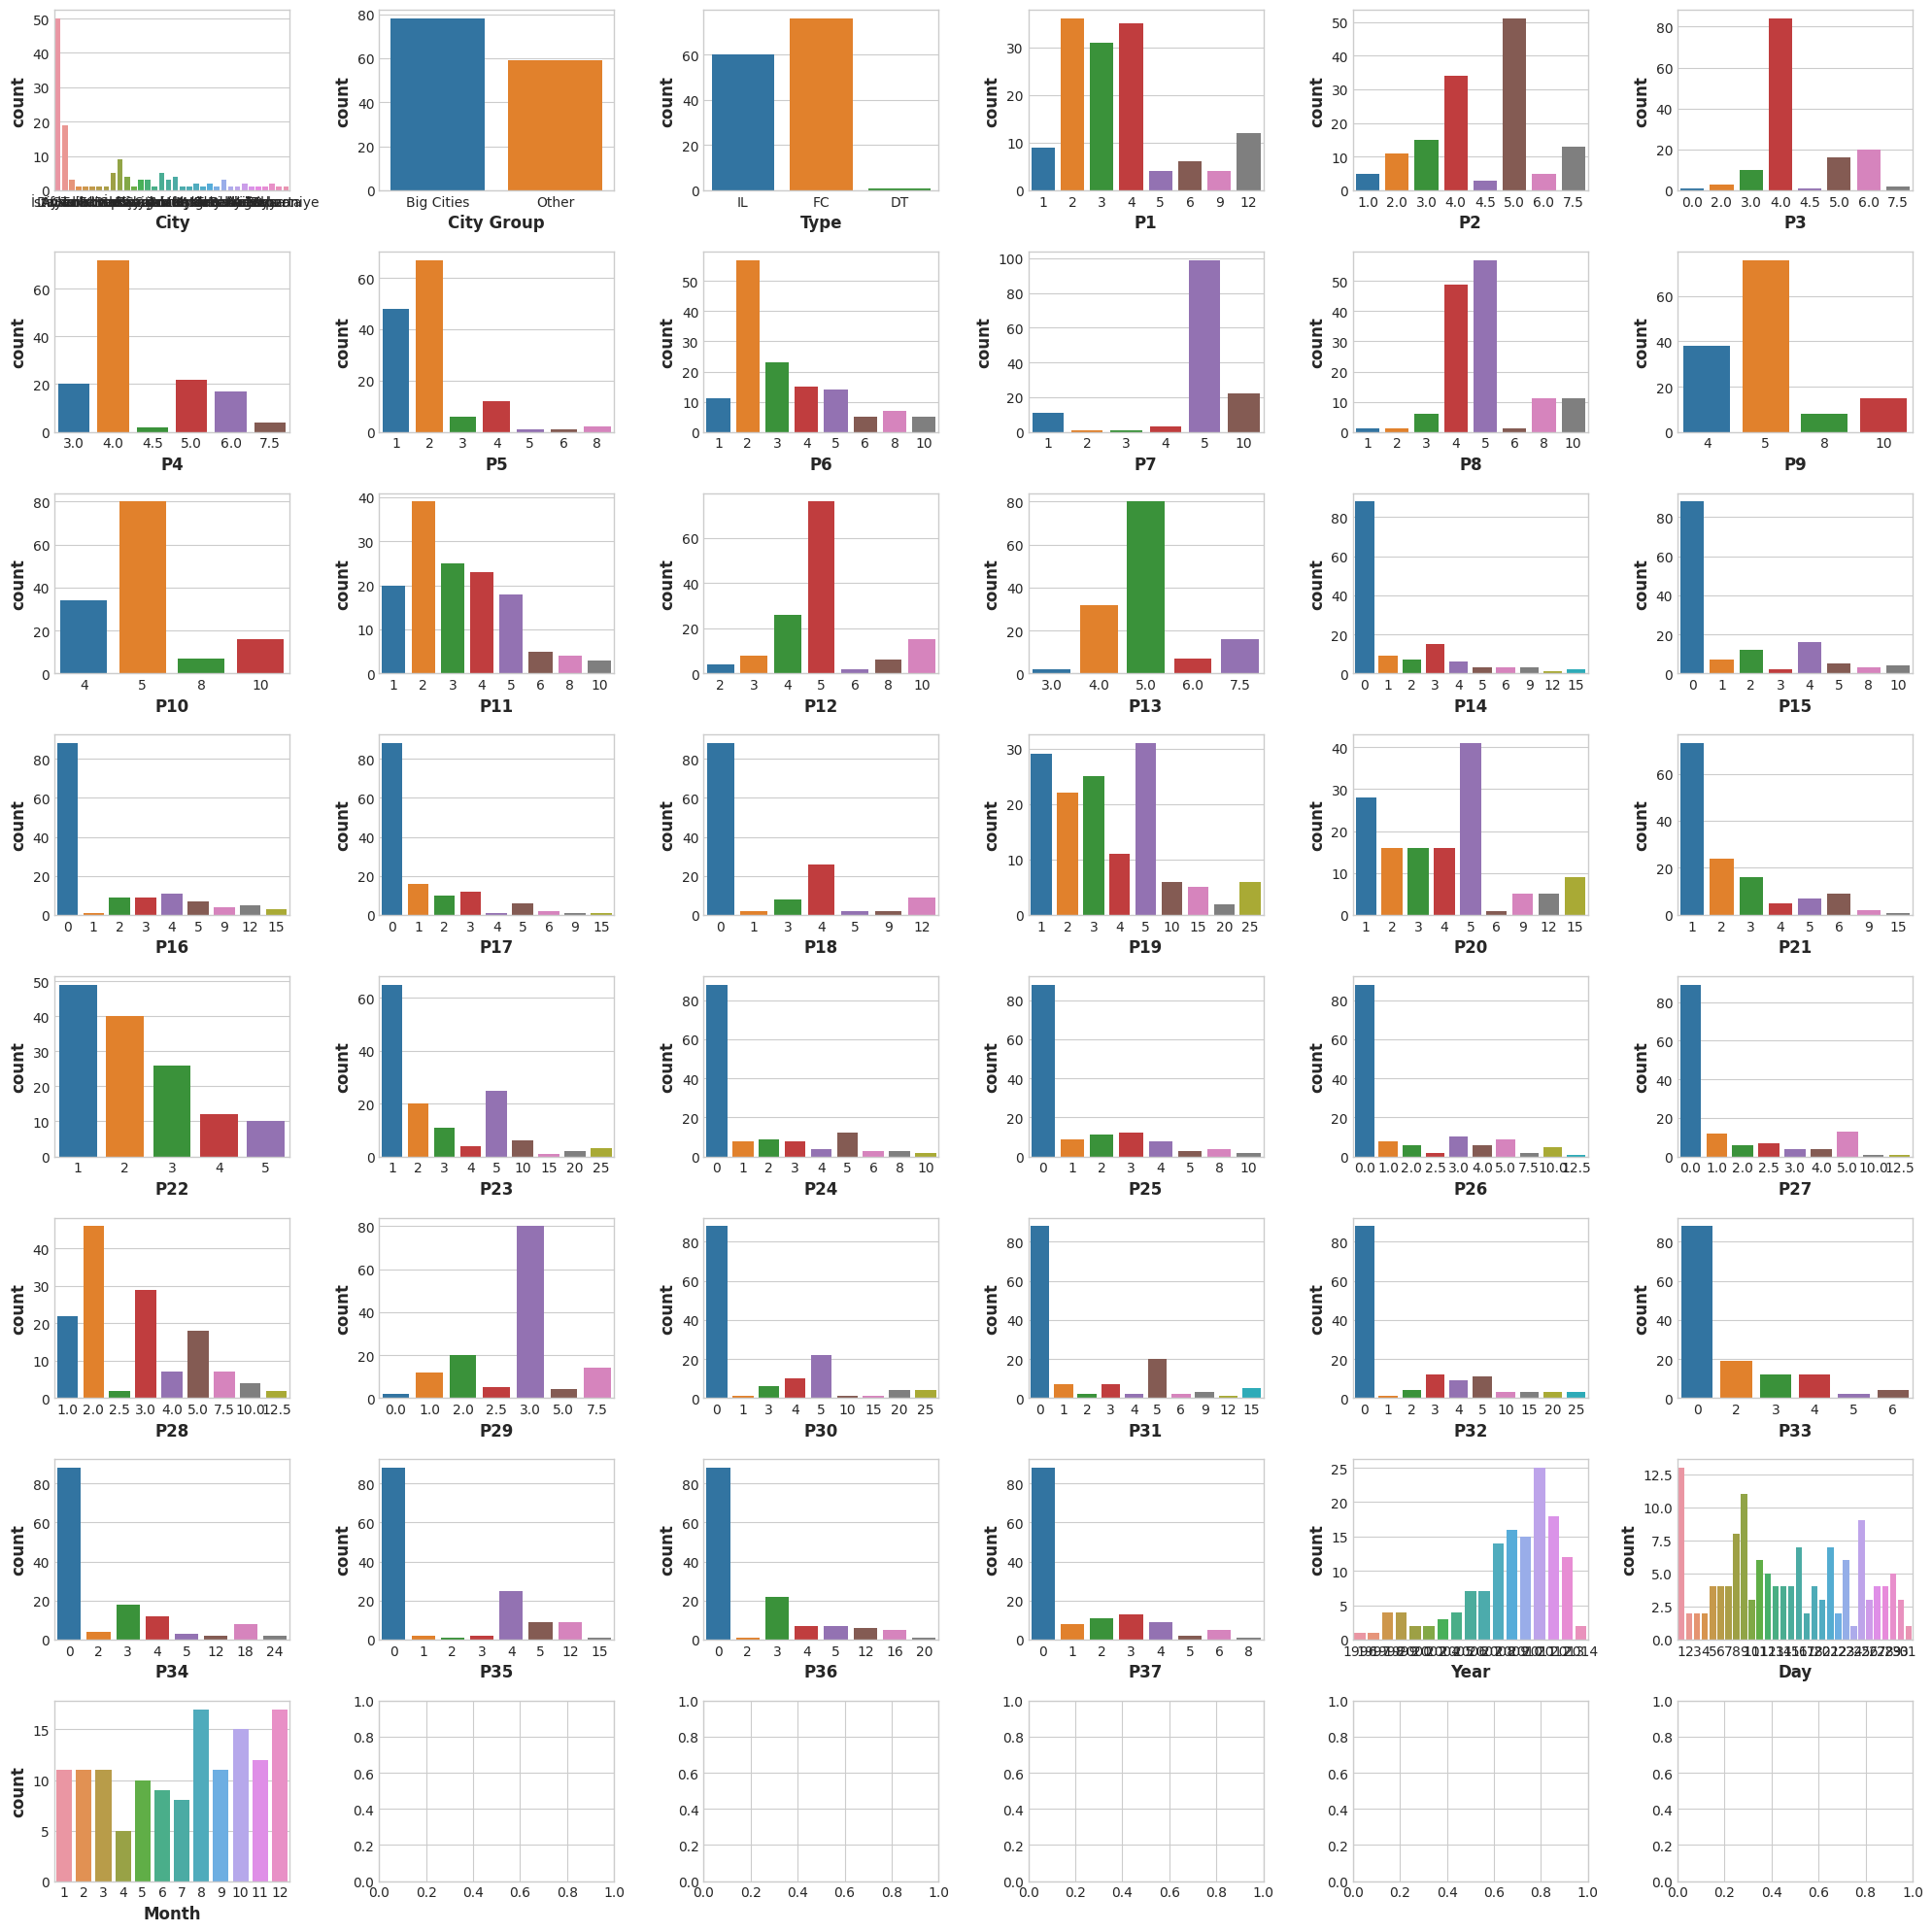

In [59]:
fig, axes = plt.subplots(8, 6, figsize=(20, 20))

for name, ax in zip(X_train.columns, axes.flatten()):
    sns.countplot(x=name, data=X_train, ax=ax)

Target distribution

/tmp/ipykernel_242/1433665995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data[value] = _data['revenue']
/tmp/ipykernel_242/1433665995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data[value] = _data['revenue']
/tmp/ipykernel_242/1433665995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

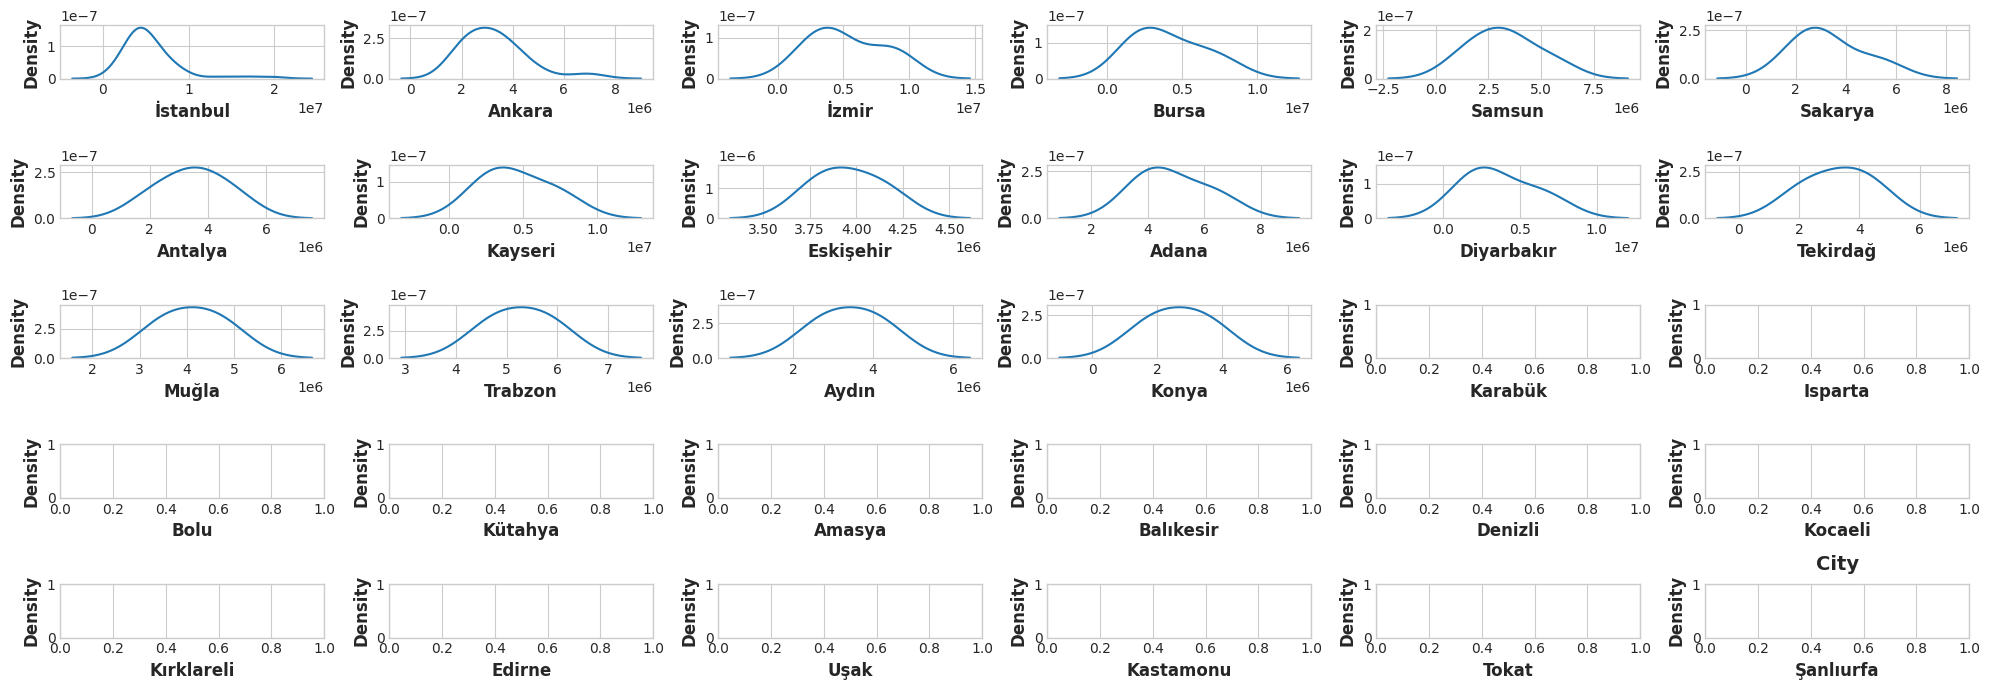

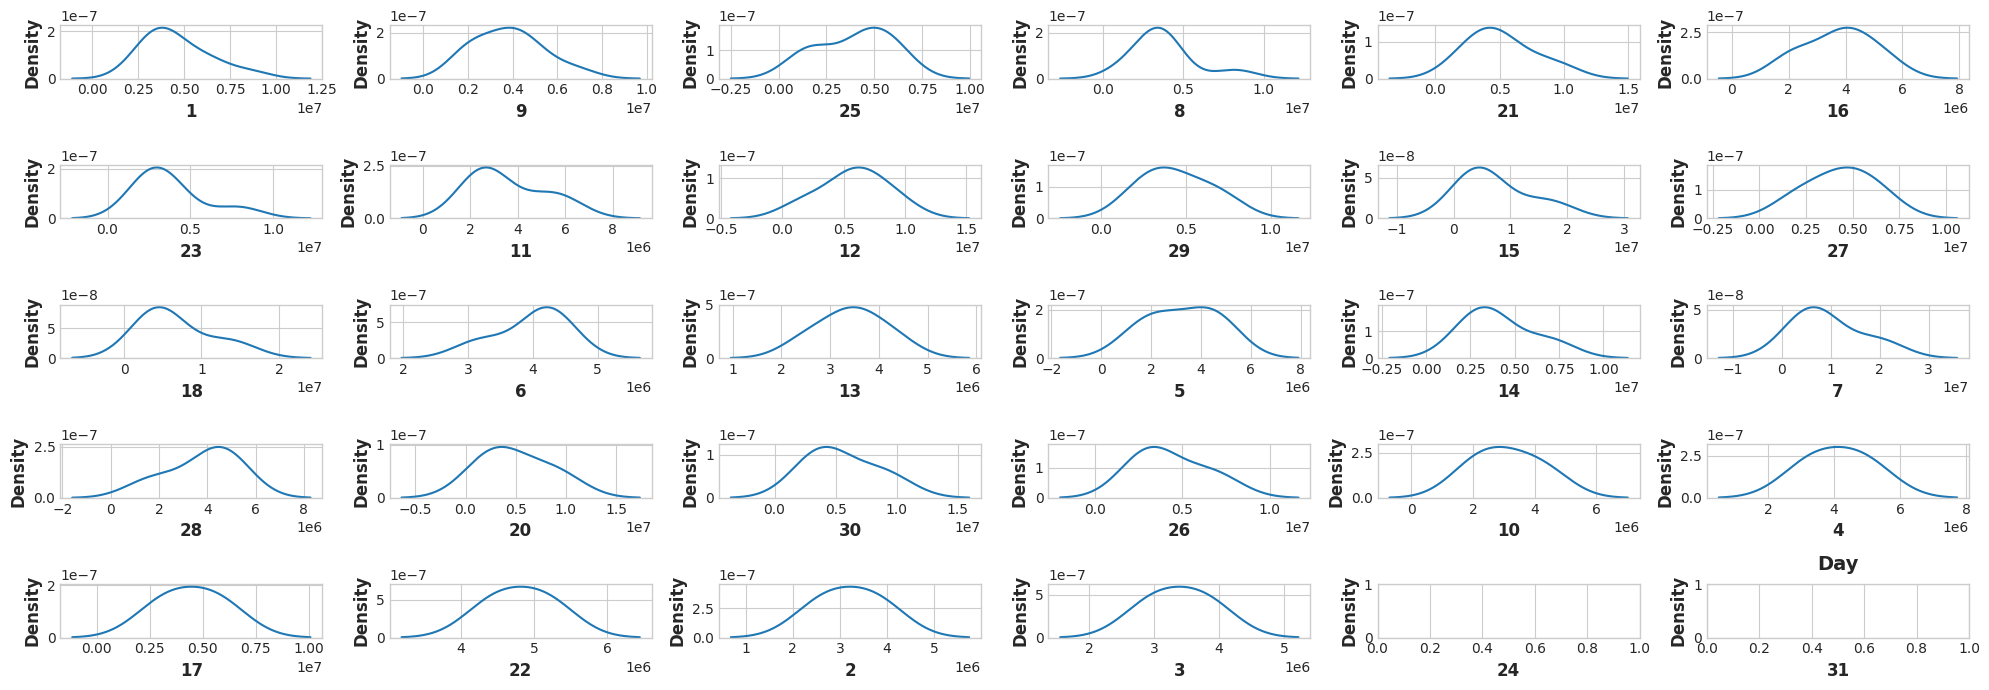

In [70]:
def targetshow(x):
    plot_num = X_train[x].nunique()
    fig, axes = plt.subplots(5, int(np.floor(plot_num/5)), figsize=(20, 7))

    data = pd.concat([X_train, y_train], axis = 1)
    values = data[x].value_counts().index.values
    
    for value, ax in zip(values, axes.flatten()):
        _data = data[data[x] == value]
        _data[value] = _data['revenue']

        sns.kdeplot(data=_data[value], ax=ax)
    
    plt.title(x)
 
a = X_train.nunique()

for col in ['City', 'Day']:
    targetshow(col)

### Encoding

One-hot encoding

In [97]:
oh_features = ['City Group', 'Type', 'Year', 'Month']

In [98]:
oh_enc = OneHotEncoder(handle_unknown = 'ignore')

arr = oh_enc.fit_transform(X_train[oh_features]).toarray()
X_train = pd.concat([X_train, pd.DataFrame(arr, columns = oh_enc.get_feature_names_out()).astype('int64')], axis = 1)
X_train = X_train.drop(oh_features, axis = 1)

arr2 = oh_enc.transform(X_test[oh_features]).toarray()
X_test = pd.concat([X_test, pd.DataFrame(arr2, columns = oh_enc.get_feature_names_out()).astype('int64')], axis = 1)
X_test = X_test.drop(oh_features, axis = 1)

Label encoding

In [105]:
lab_features = ['City']

In [108]:
lab_enc = LabelEncoder()

lab_enc.fit(pd.concat([X_train[lab_features], X_test[lab_features]], axis = 0))

X_train[lab_features] = lab_enc.transform(X_train[lab_features])
X_test[lab_features] = lab_enc.transform(X_test[lab_features])

X_train.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

Target encoding

In [72]:
t_features = ['City', 'Day']

In [73]:
t_enc = TargetEncoder()

X_train[t_features] = t_enc.fit_transform(X_train[t_features], y_train)
X_test[t_features] = t_enc.transform(X_test[t_features])

X_train.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P31,P32,P33,P34,P35,P36,P37,Year,Day,Month
0,5.577812e+06,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,3,4,5,5,4,3,4,1999,17,7
1,3.275406e+06,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,0,2008,14,2
2,3.820961e+06,Other,IL,2,4.0,2.0,5.0,2,3,5,...,0,0,0,0,0,0,0,2013,9,3
3,4.453533e+06,Other,IL,6,4.5,6.0,6.0,4,4,10,...,12,10,6,18,12,12,6,2012,2,2
4,4.453533e+06,Other,IL,3,4.0,3.0,4.0,2,2,5,...,1,3,2,3,4,3,3,2009,9,5


In [77]:
p_columns = ['P%s' % i for i in range(1, 38)]

In [78]:
X_train[p_columns] = X_train[p_columns].astype('float64')
X_test[p_columns] = X_test[p_columns].astype('float64')

### Scaling

In [80]:
scaler = StandardScaler()
scaling_features = t_features + p_columns

scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[scaling_features]), columns = scaling_features)
scaled_X_test = pd.DataFrame(scaler.transform(X_test[scaling_features]), columns = scaling_features)

X_train[scaling_features] = scaled_X_train
X_test[scaling_features] = scaled_X_test

X_train.describe()

,City,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
count,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,1.370000e+02,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,-5.154028e-16,5.875268e-17,-2.512183e-16,1.491102e-16,3.371188e-16,1.539725e-16,6.320978e-17,-6.807207e-17,1.426272e-16,-1.102119e-16,...,0.080292,0.036496,0.072993,0.065693,0.058394,0.124088,0.080292,0.109489,0.087591,0.124088
std,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,1.003670e+00,...,0.272742,0.188210,0.261079,0.248655,0.235348,0.330891,0.272742,0.313398,0.283737,0.330891
min,-1.532242e+00,-1.039607e+00,-2.258412e+00,-4.197623e+00,-1.354992e+00,-8.357959e-01,-1.108742e+00,-1.932938e+00,-2.242871e+00,-7.905845e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.126217e+00,-6.947492e-01,-2.708160e-01,-3.087009e-01,-3.675777e-01,-8.357959e-01,-6.384707e-01,-1.850007e-01,-6.228007e-01,-7.905845e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.365330e-01,-3.498918e-01,3.917159e-01,-3.087009e-01,-3.675777e-01,-6.056492e-03,-1.681993e-01,-1.850007e-01,-8.277730e-02,-2.435639e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.065090e+00,-5.034415e-03,3.917159e-01,6.635295e-01,6.198369e-01,-6.056492e-03,3.020722e-01,-1.850007e-01,-8.277730e-02,-2.435639e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.065090e+00,2.753825e+00,2.048046e+00,3.094106e+00,3.088374e+00,4.972380e+00,3.123701e+00,1.999921e+00,2.617340e+00,2.491539e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection

In [92]:
discrete_features = X_train.dtypes == 'int64'
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=True)
mi_scores

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

### Modeling and Scoring

LGBM

In [81]:
# grid search
params = {
    'learning_rate' : [0.01, 0.04, 0.07, 0.1],
    'n_estimators' : [100, 300, 500, 1000],
    'max_depth' : [5, 7]
}

model = lgbm.LGBMRegressor()
grid_lgbm = GridSearchCV(model, param_grid=params, scoring = 'neg_mean_squared_error', cv=3, refit=True)
grid_lgbm.fit(X_train, y_train)

print('best params : ', grid_lgbm.best_params_)
print('best score : ', grid_lgbm.best_score_)

best params :  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
best score :  -5848341712316.458


XGBoost

In [82]:
# grid search
params = {
    'learning_rate' : [0.01, 0.04, 0.07, 0.1],
    'n_estimators' : [100, 300, 500, 1000],
    'max_depth' : [5, 7]
}

model = xgb.XGBRegressor()
grid_xgb = GridSearchCV(model, param_grid=params, scoring = 'neg_mean_squared_error', cv=3, refit=True)
grid_xgb.fit(X_train, y_train)

print('best params : ', grid_xgb.best_params_)
print('best score : ', grid_xgb.best_score_)

best params :  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
best score :  -6980906684674.243


### Submission

In [85]:
y_test = grid_xgb.best_estimator_.predict(X_test)
submission = pd.DataFrame(y_test, columns=['Prediction'])
submission = pd.concat([test['Id'], submission], axis = 1)
submission.head()

,Id,Prediction
0,0,2749578.75
1,1,2846291.75
2,2,3432165.75
3,3,2860233.00
4,4,3878820.50


In [86]:
submission.to_csv("./submission.csv", index = False)